# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [1]:
import pandas as pd

In [2]:
X=pd.read_csv('orange_small_churn_data.txt')
Y=pd.read_csv('orange_small_churn_labels.txt',header=None)

In [3]:
Y.head()

,0
0,-1
1,-1
2,-1
3,1
4,-1


In [4]:
Y.shape

(40000, 1)

In [5]:
X.shape

(40000, 230)

In [6]:
Y.rename(columns={0: 'label'},inplace=True)

In [7]:
Y.head()

,label
0,-1
1,-1
2,-1
3,1
4,-1


2\. Рассчитайте доли классов `отток` и `не отток`.

In [8]:
Y.groupby('label')['label'].count()/40000

label
-1    0.9256
 1    0.0744
Name: label, dtype: float64

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

посчитаем корреляцию м/у вещ признаками и бинарным по формуле E(X1|X2 = 1) - E(X1|X2 = -1)/ катергар. исключим

In [9]:
num=X.iloc[:, 0:190]

In [10]:
num['labels']=Y

In [11]:
cor_num = num[num['labels'] == 1].mean() - num[num['labels'] == -1].mean()

In [12]:
cor_num = cor_num.drop('labels')

In [13]:
cor_num.sort_values(ascending=False)

Var131    1.034608e+07
Var69     4.808584e+05
Var53     4.389077e+05
Var177    4.017487e+05
Var180    3.201630e+05
              ...     
Var141             NaN
Var167             NaN
Var169             NaN
Var175             NaN
Var185             NaN
Length: 190, dtype: float64

In [14]:
cor_num[cor_num.sort_values(ascending=False).isnull()]

Var8     NaN
Var15    NaN
Var20    NaN
Var31    NaN
Var32    NaN
Var39    NaN
Var42    NaN
Var48    NaN
Var52    NaN
Var55    NaN
Var79    NaN
Var141   NaN
Var167   NaN
Var169   NaN
Var175   NaN
Var185   NaN
dtype: float64

посчитаем корелляцию м/у кат признаками и бинарным / Построим табл сопряженности и вычислим коэф Крамера

In [15]:
import scipy.stats as ss
import numpy as np


In [16]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [17]:
cat=X.iloc[:, 190:]

In [18]:
cat['labels']=Y

In [19]:
corr_cat=pd.DataFrame(columns = ['feature', 'corr'])
cor_cat=[]
for i in range(191,231):
    if cat['Var' + str(i)].isnull().sum() == cat.shape[0]:
        cor_cat.append(0.0)
        
    else: 
        confusion_matrix = pd.crosstab(cat['Var' + str(i)], cat['labels'])
        cor_cat.append(cramers_corrected_stat(confusion_matrix))
    

C:\Users\unikum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [20]:
corr_cat=pd.DataFrame({'featire': X.iloc[:, 190:].columns, 'corr': np.array(cor_cat)})

In [21]:
corr_cat.sort_values(by='corr', ascending=False).head()

,featire,corr
8,Var199,0.237375
1,Var192,0.116264
25,Var216,0.083442
15,Var206,0.077436
21,Var212,0.075150


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

**Здесь и далее буду рассматривать 10 признаков  / не тянет ноутбук) сорян**

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
features=np.array(cor_num.abs().sort_values(ascending=False)[:10].index)

C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\unikum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


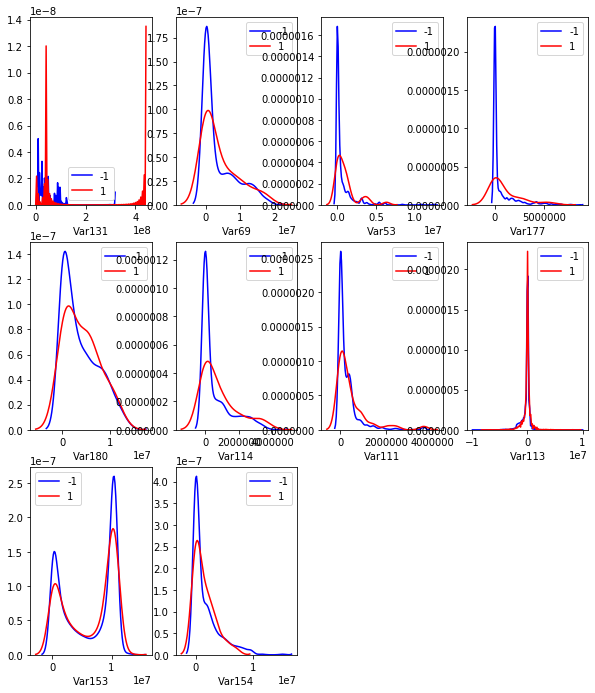

In [24]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in features:
    plot_number += 1
    pyplot.subplot(5, 4, plot_number)
    colors = {-1: 'b', 1: 'r'}
    for i in [-1, 1]:
        sns.distplot(num[num['labels'] == i][column], color=colors[i], hist=False, label = i)
        

C:\Users\unikum\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\unikum\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


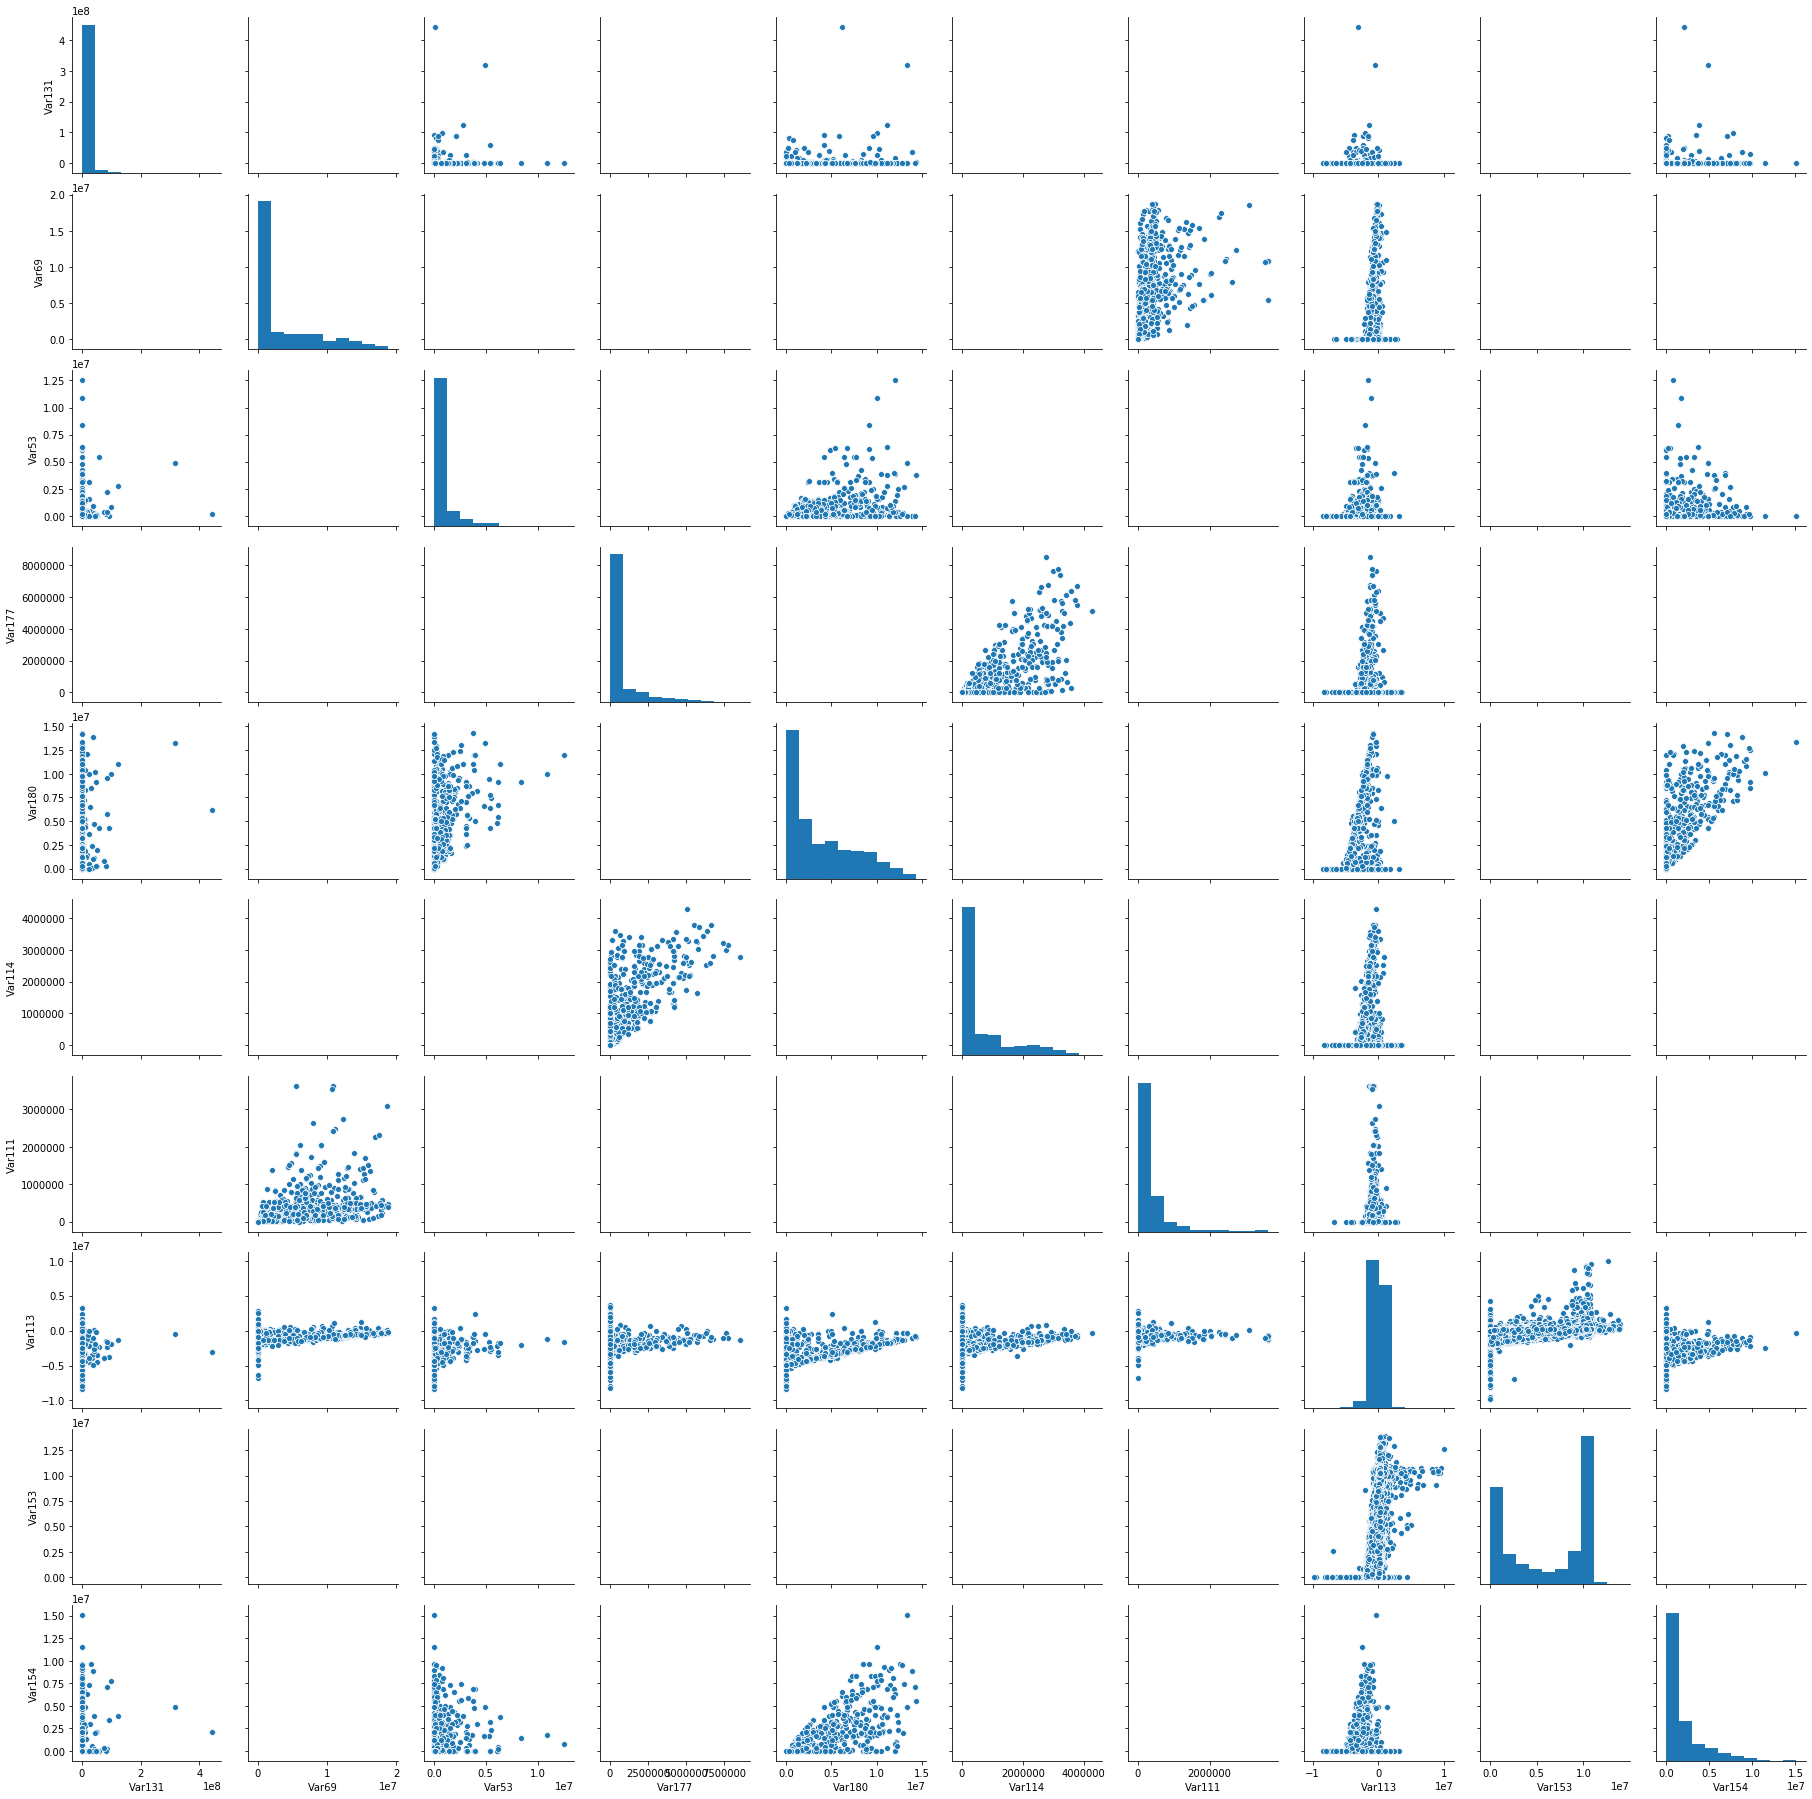

In [25]:
sns.pairplot(num[features])

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

удалими null признаки / может попасть в рандом 

In [26]:
cor_num[cor_num.isnull()].index

Index(['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48',
       'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175',
       'Var185'],
      dtype='object')

In [27]:
cor_num.drop(cor_num[cor_num.isnull()].index)

Var1          1.670494
Var2         -0.005181
Var3       -167.782993
Var4          0.016095
Var5     -66949.866756
              ...     
Var186       -0.458211
Var187        2.679840
Var188       54.594774
Var189      -40.199637
Var190    -5216.922538
Length: 174, dtype: float64

In [28]:
num_after_del = num.drop(cor_num[cor_num.isnull()].index , axis='columns')

In [29]:
features_random = np.array(cor_num.drop(cor_num[cor_num.isnull()].index)[np.random.randint(1, 174, size = 10)].index)

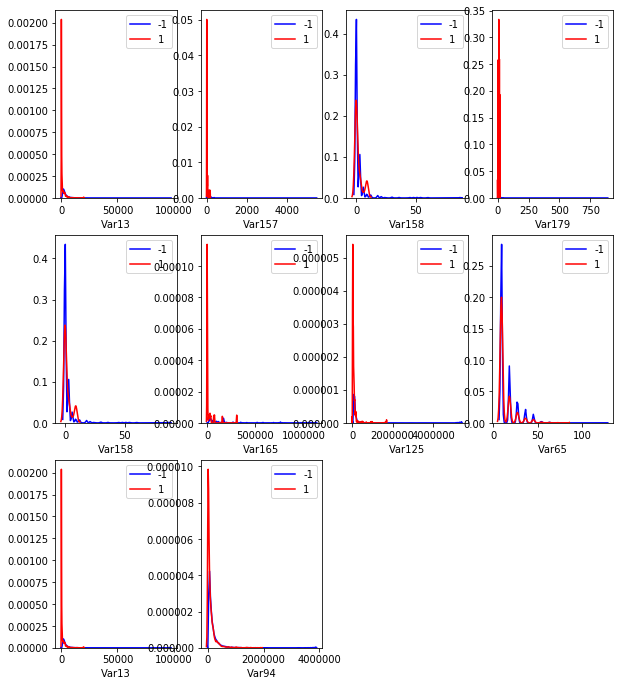

In [30]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in features_random:
    plot_number += 1
    pyplot.subplot(5, 4, plot_number)
    colors = {-1: 'b', 1: 'r'}
    for i in [-1, 1]:
        sns.distplot(num[num['labels'] == i][column], color=colors[i], hist=False, label = i)

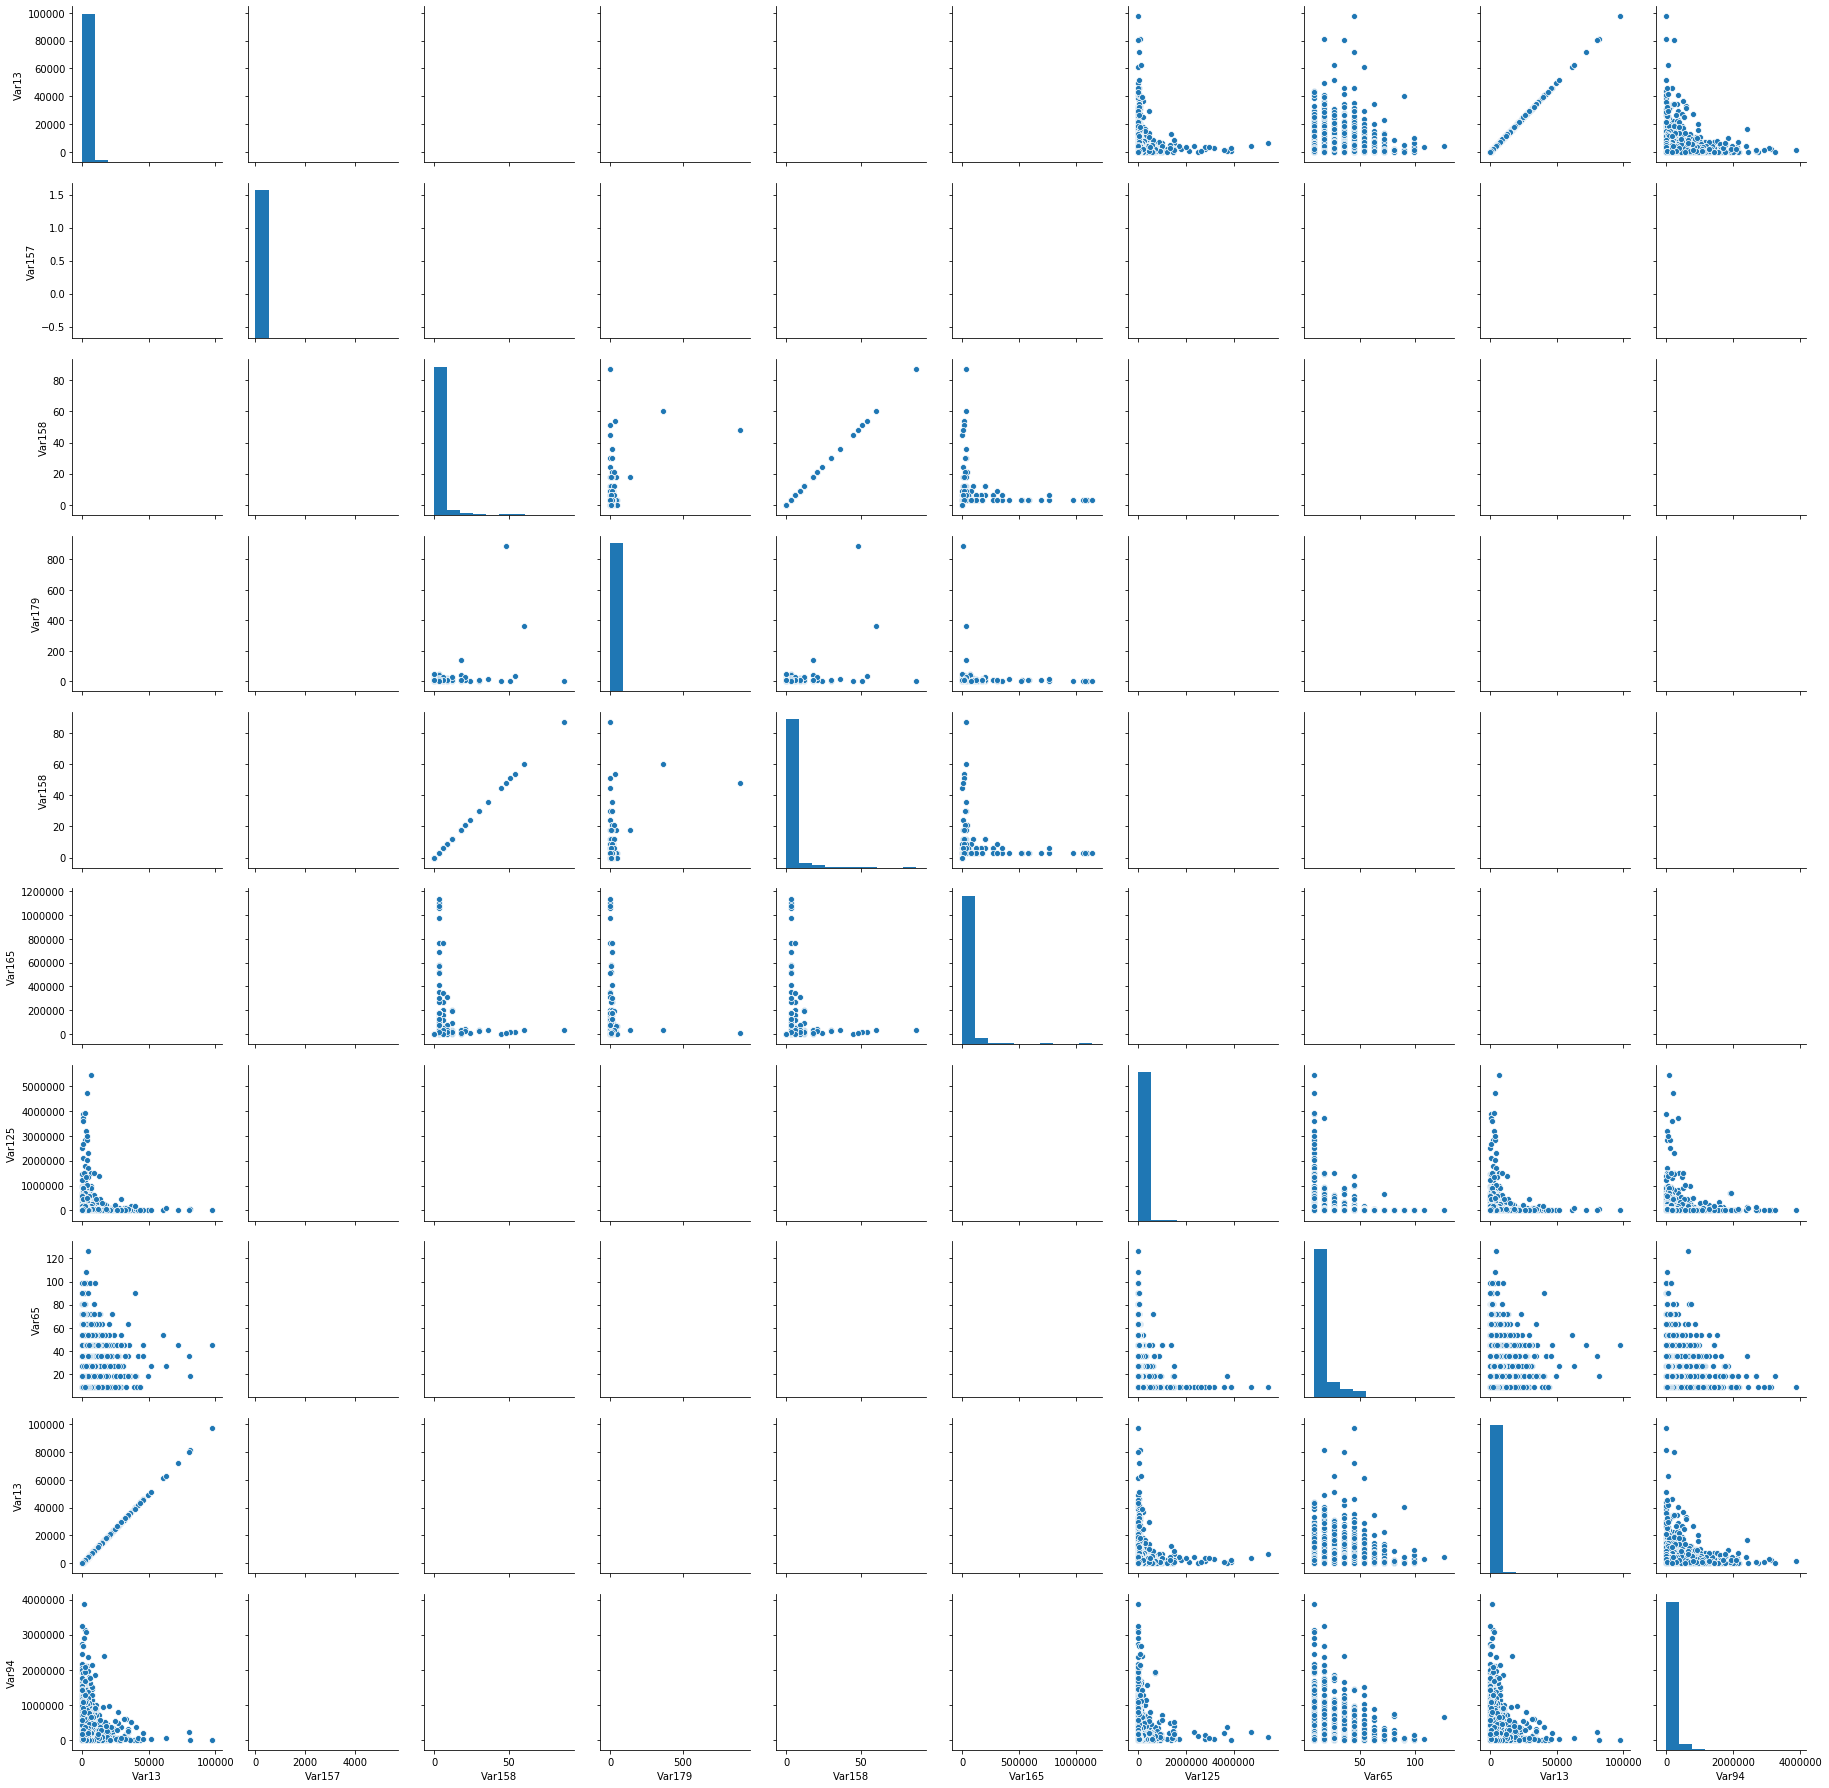

In [37]:
sns.pairplot(num, vars=features_random)

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [38]:
features_low=np.array(cor_num.abs().sort_values(ascending=True)[:10].index)

C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\unikum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


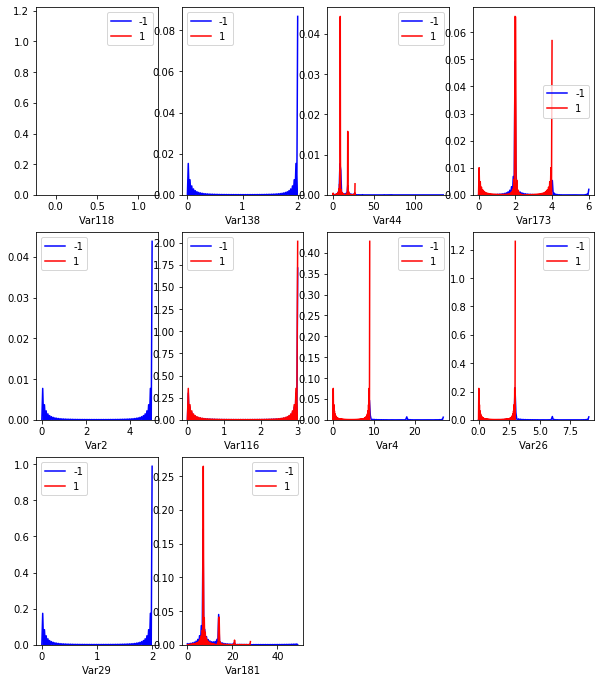

In [39]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in features_low:
    plot_number += 1
    pyplot.subplot(5, 4, plot_number)
    colors = {-1: 'b', 1: 'r'}
    for i in [-1, 1]:
        sns.distplot(num[num['labels'] == i][column], color=colors[i], hist=False, label = i)

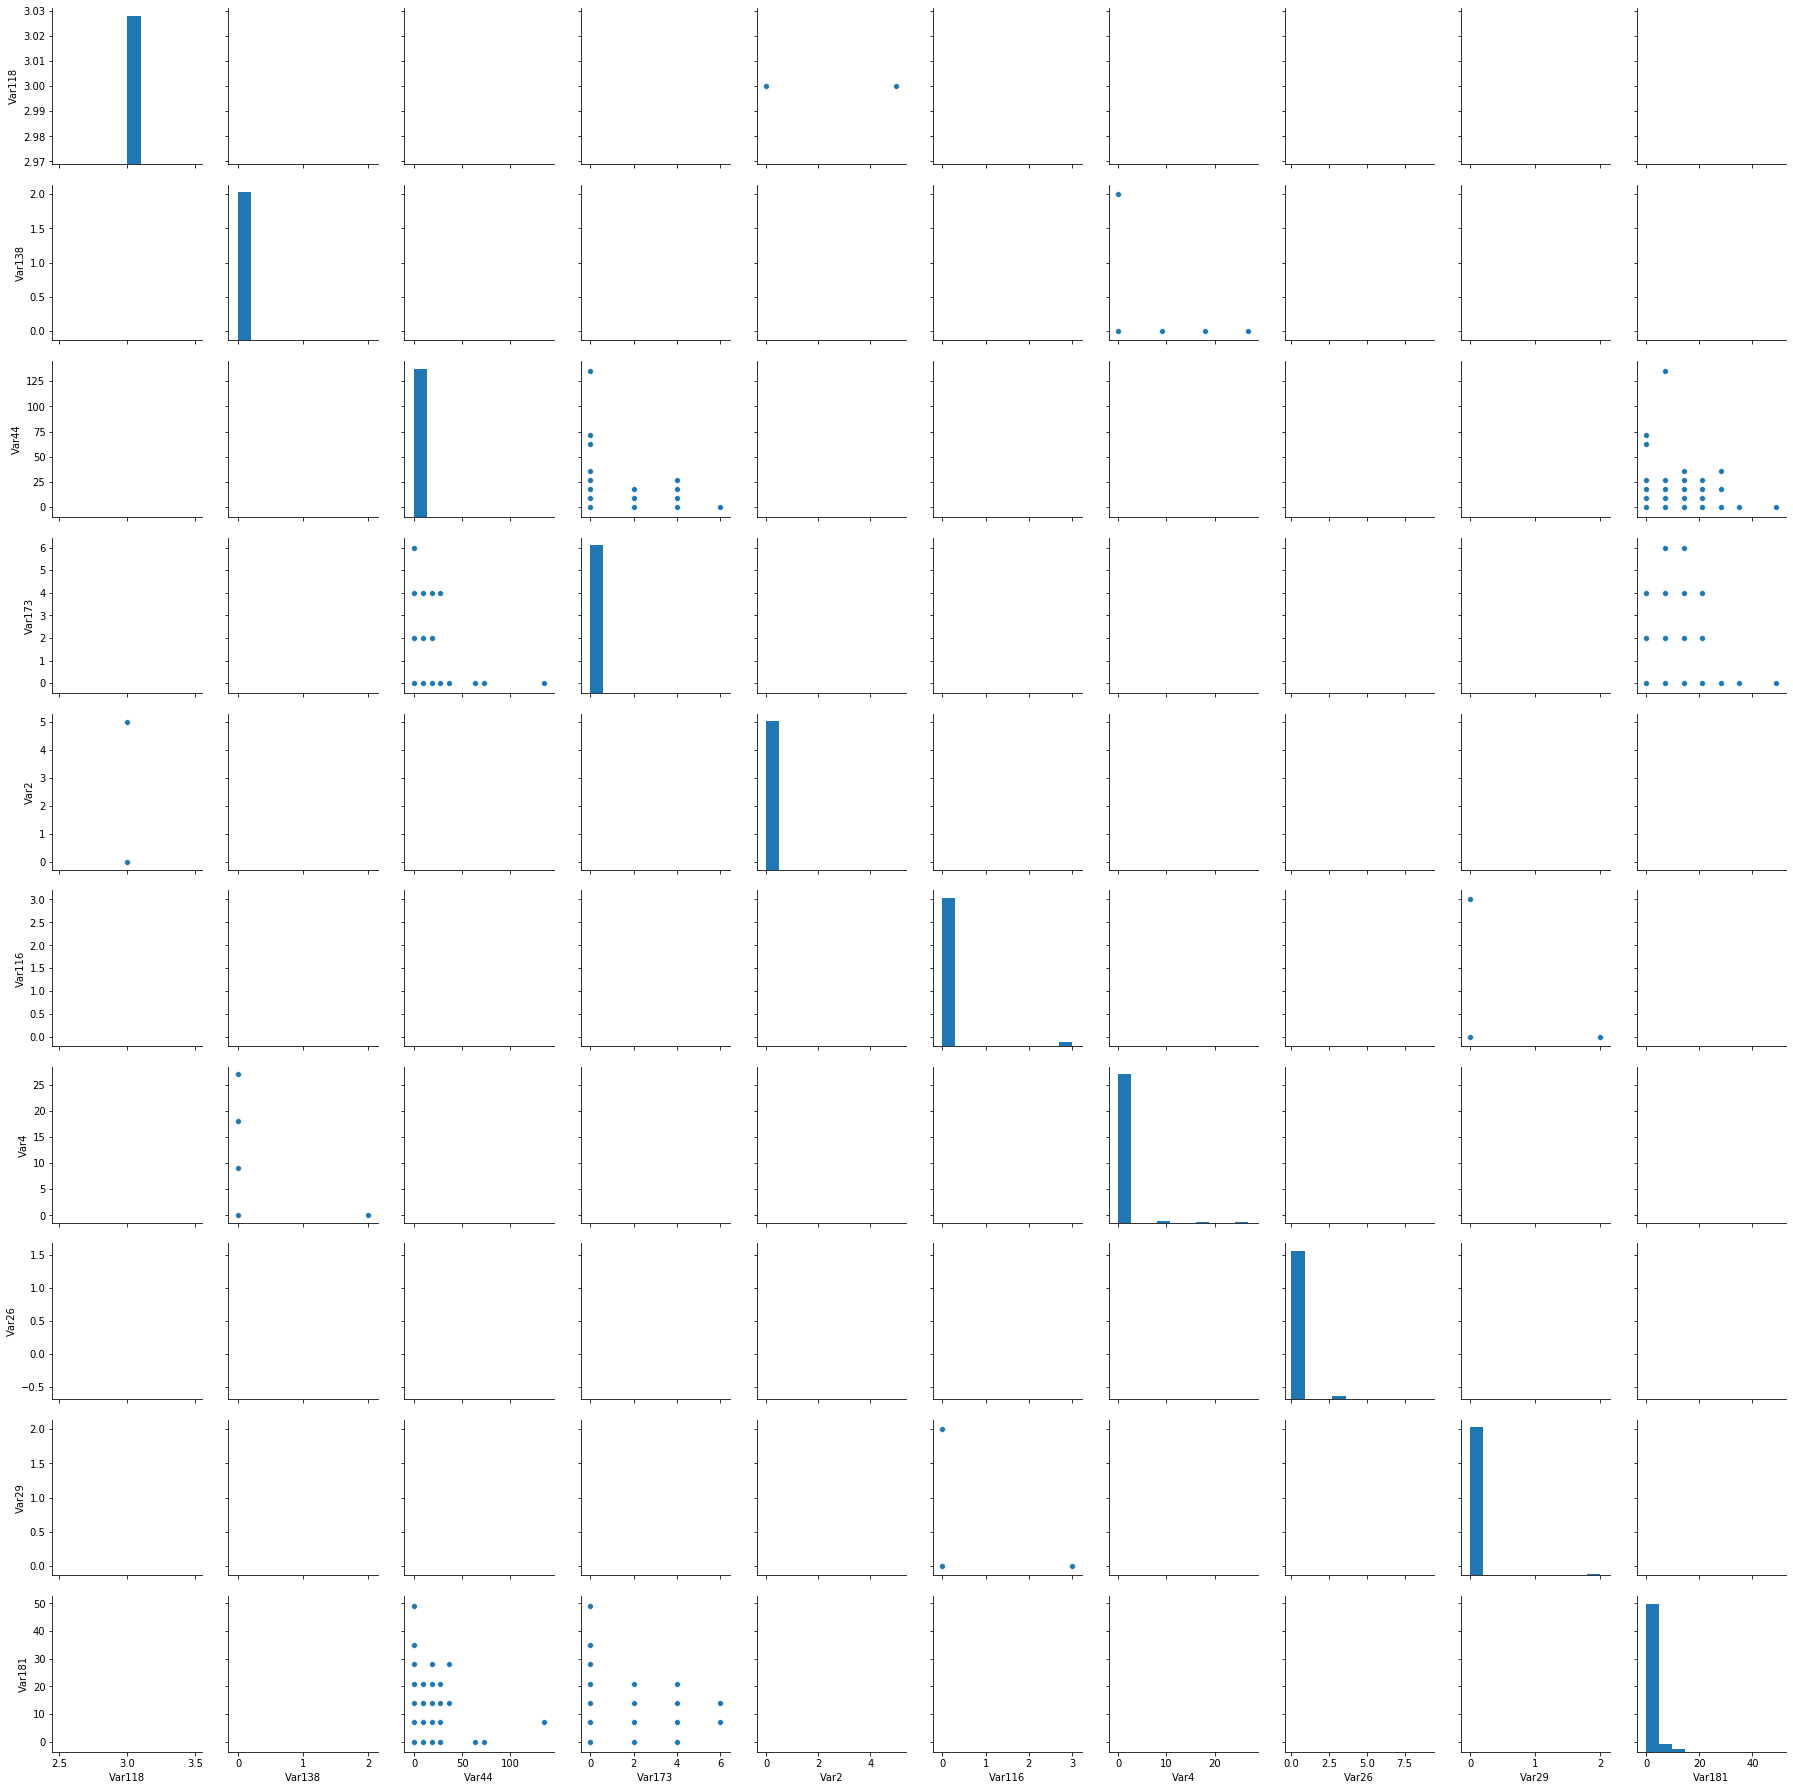

In [40]:
sns.pairplot(num[features_low])

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

пропустим полностью null -ые признаки

In [41]:
cat.columns

Index(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197',
       'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204',
       'Var205', 'Var206', 'Var207', 'Var208', 'Var209', 'Var210', 'Var211',
       'Var212', 'Var213', 'Var214', 'Var215', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var224', 'Var225',
       'Var226', 'Var227', 'Var228', 'Var229', 'Var230', 'labels'],
      dtype='object')

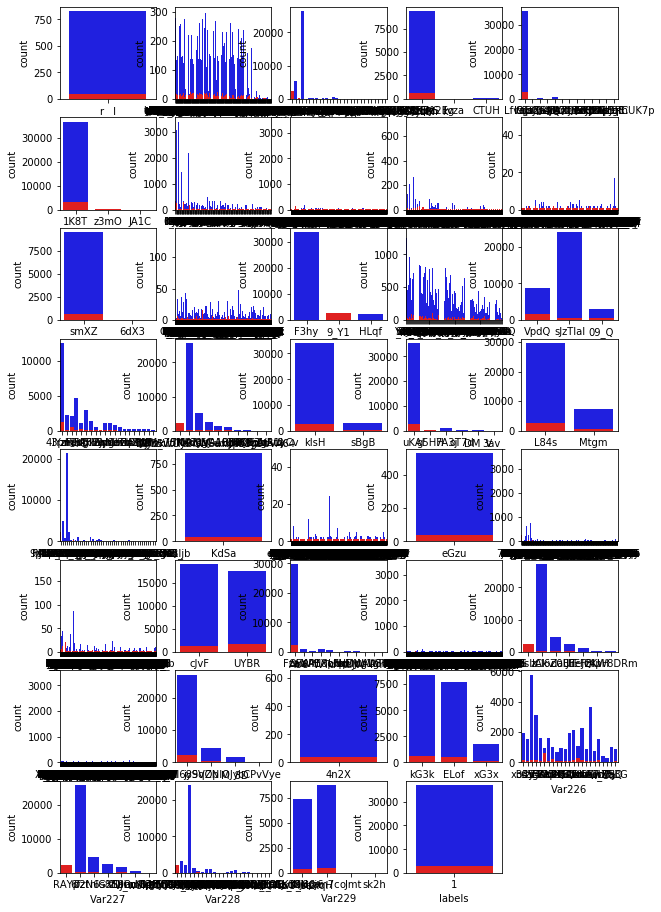

In [42]:
pyplot.figure(figsize(10, 20))
plot_number = 0
for column in cat.columns:
    if cat[column].isnull().sum() == cat.shape[0]:
        continue
    else:
        plot_number += 1
        pyplot.subplot(10, 5, plot_number)
        colors = {-1: 'b', 1: 'r'}
        for i in [-1, 1]:
            sns.countplot(cat[cat['labels'] == i][column], color=colors[i], label = i)

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

    1. Данные сильно разреженны. очень много NaNов ( более 95% в признаке). Среди коррелирующих признаков видна разница в плотоности относительно целевого признака , например Var53. Есть вещественные признаки с 3 - 4 значениями, например Var173
    2. Окажут те признаки, в которых значений (не NaN) больше 80%. До проверки на пропуски важными признаками являются Var131    Var69. Среди категориальных - Var199
    3. Те переменные, в которых больше 95% Nanов. Требуется дополнительно проверить. Но уже сейчас можно признаки Var8, Var15, Var20 (100% Nan) т.д назвать шумовыми - их следовало бы удалить сразу
    4. ДА. в данных полно шума. Шумовые признаки нужно удалить. Nanы заполнить. 


Начнем с простого, но важного шага. Отделите небольшую выборку от существующих данных. Назовем её hold-out dataset. Эта выборка нужна для контроля качества решения: она не должна использоваться вплоть до контроля качества решения. Наличие такой выборки поможет убедиться, что в процессе моделирования не было допущено ошибок, не произошло переобучение. В качестве ответа загрузите полученный файл (или файлы, если вы работаете а данными и метками как с 2мя файлами)

In [47]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=123)

In [67]:
pd.value_counts(Y.label)[1]/pd.value_counts(Y.label)[-1]

0.08038029386343994

In [68]:
pd.value_counts(y_test.label)[1]/pd.value_counts(y_test.label)[-1]

0.08695652173913043

In [69]:
X_test['labels']= y_test

C:\Users\unikum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
X_test.to_csv("Hold-out Dataset.csv",index = False)